# 白盒攻击

In [1]:
import os
import torch
from torch import nn, optim
from tqdm import tqdm

import utils

model_dict_path = "./white_model_1.pt"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## 1. 模型定义

In [2]:
net = utils.white_model()
net.to(device)

white_model(
  (infer): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): FlattenLayer()
    (7): Linear(in_features=3136, out_features=1024, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.4)
    (10): Linear(in_features=1024, out_features=10, bias=True)
  )
)

## 2. 加载数据

In [3]:
batch_size = 256
train_iter, test_iter = utils.load_data_fashion_mnist(batch_size=batch_size)

## 3. 训练或者加载模型

In [4]:
if os.path.exists(model_dict_path):
    print("加载之前训练好的模型...", end="")
    net.load_state_dict(torch.load(model_dict_path))
    print("完成.")
    print("test acc: ", utils.evaluate_accuracy(test_iter, net))
else:
    print("训练模型...") 
    lr, num_epochs = 0.001, 10
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    utils.train(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs)
    print("保存模型...", end="")
    torch.save(net.state_dict(), model_dict_path)
    print("完成.")

加载之前训练好的模型...完成.
test acc:  0.9197


## 4. 选取1000个成功分类的样本

In [5]:
net.eval()
X_test, y_test = utils.select_right_sample(net, test_iter)

assert (net(X_test.to(device)).argmax(dim=1) == y_test.to(device)).float().sum().cpu().item() == 1000.0

## 5. 攻击

100%|██████████| 1000/1000 [00:37<00:00, 27.01it/s]


学习率0.010,最大步数50的白盒攻击成功率: 98.10%
成功样本举例:

攻击前:


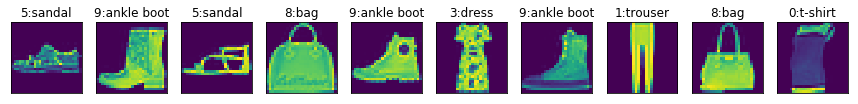

攻击后:


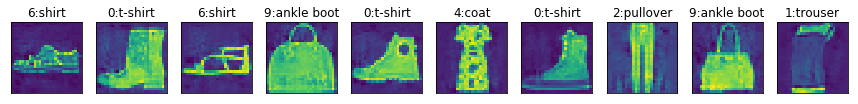

In [6]:
attack_lr, max_attack_step = 0.01, 50
before_atk_X, before_atk_y = [], []
after_atk_X, after_atk_y = [], []
for i in tqdm(range(1000)):
    X_, y_, success = utils.white_box_attack(net, X_test[i:i+1], y_test[i:i+1], attack_lr, max_attack_step)
    if success:
        before_atk_X.append(X_test[i])
        before_atk_y.append(y_test[i])
        after_atk_X.append(X_)
        after_atk_y.append(y_)
print("学习率%.3f,最大步数%d的白盒攻击成功率: %.2f%%" % (attack_lr, max_attack_step, len(after_atk_y) / 10))
print("成功样本举例:\n")
print("攻击前:")
utils.show_fashion_mnist(before_atk_X[:10], utils.get_fashion_mnist_labels(before_atk_y[:10]))
print("攻击后:")
utils.show_fashion_mnist(after_atk_X[:10], utils.get_fashion_mnist_labels(after_atk_y[:10]))